In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
import random
import torch
import time
import datetime

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Set Data

In [2]:
train_dir = 'Dataset/TrainData'
valid_perc = 0.01

In [3]:
# LOAD DATASET INTO A MODEL-ACCEPTABLE FORMAT

from detectron2.structures import BoxMode

json_file = os.path.join(train_dir, 'MIDOG_new.json')
with open(json_file) as f:
    annotation = json.load(f)
        
dataset_dict = []
for i, image in enumerate(annotation['images']):
    record = {}
        
    file_name = os.path.join(train_dir + '/images', image['file_name'])
    height, width = image['height'], image['width']
        
    record['file_name'] = file_name
    record['image_id'] = image['id']
    record['height'] = image['height']
    record['width'] = image['width']
        
    record['annotations'] = []
    dataset_dict.append(record)
    
for j, anno in enumerate(annotation['annotations']):
    obj = {
        'bbox': [anno['bbox'][0], anno['bbox'][1], anno['bbox'][2], anno['bbox'][3]],
        'bbox_mode': BoxMode.XYXY_ABS, # could have been BoxMode.XYWH_ABS which would have bbox (x_min,y_min,width,height) and not (x_min, y_min, x_max, y_max)
        'category_id': anno['category_id']-1
    }
    dataset_dict[anno['image_id']-1]['annotations'].append(obj)        

In [4]:
len(dataset_dict)

4435

In [5]:
# SPLIT DATASET INTO TRAIN AND TEST

indexes = np.random.randint(0, 151, int(valid_perc * len(dataset_dict)))
dataset_dict_valid = []
dataset_dict_train = []
for i, img in enumerate(dataset_dict):
    if i in indexes:
        dataset_dict_valid.append(img)
    else:
        dataset_dict_train.append(img)
del dataset_dict

In [6]:
len(dataset_dict_valid), len(dataset_dict_train)

(38, 4397)

In [7]:
def get_dataset_dict_train():
    return dataset_dict_train
def get_dataset_dict_valid():
    return dataset_dict_valid

In [8]:
DatasetCatalog.register('train', get_dataset_dict_train) # Store dataset
MetadataCatalog.get('train').set(thing_classes=['mitotic figure', 'not mitotic figure']) # Store labels
mitosis_metadata = MetadataCatalog.get('train') # Save MetaCatalog of labels (for later usage)

In [9]:
DatasetCatalog.register('valid', get_dataset_dict_valid) # Store dataset
MetadataCatalog.get('valid').set(thing_classes=['mitotic figure', 'not mitotic figure']) # Store labels
mitosis_metadata = MetadataCatalog.get('valid') # Save MetaCatalog of labels (for later usage)

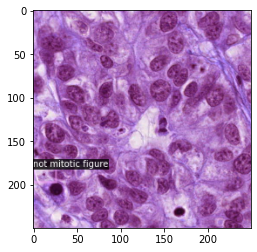

In [10]:
# Visualize train image

%matplotlib inline

for d in random.sample(dataset_dict_train, 1): # Draw 1 random sample from dataset
    img = cv2.imread(d['file_name']) # Get image from that location
    visualizer = Visualizer(img[:, :, ::-1], metadata=mitosis_metadata, scale=0.5) # Apply visualizer to the image
    out = visualizer.draw_dataset_dict(d) # Get the image from this location in dataset WITH ITS ANNOTATIONS
    im = out.get_image()[:, :, ::-1] # Show image
    plt.imshow(im)

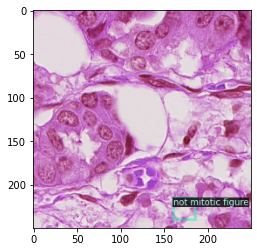

In [11]:
# Visualize validation image

%matplotlib inline

for d in random.sample(dataset_dict_valid, 1): # Draw 1 random sample from dataset
    img = cv2.imread(d['file_name']) # Get image from that location
    visualizer = Visualizer(img[:, :, ::-1], metadata=mitosis_metadata, scale=0.5) # Apply visualizer to the image
    out = visualizer.draw_dataset_dict(d) # Get the image from this location in dataset WITH ITS ANNOTATIONS
    im = out.get_image()[:, :, ::-1] # Show image
    plt.imshow(im)

# Set Configuration of Model

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml"))
cfg.DATASETS.TRAIN = ("train",) # NOTICE: this is a Tuple (Put the same name as the Dataset name)
cfg.DATALOADER.NUM_WORKERS = 2 # Thread number
cfg.OUTPUT_DIR = './output/dc5_base'

# Validation
cfg.DATASETS.TEST = ('valid',)
cfg.TEST.EVAL_PERIOD = 500

# Optimizer
cfg.SOLVER.IMS_PER_BATCH = 5 # Batch size
cfg.SOLVER.WARMUP_ITERS = 500 # Warmups the solver; the solver goes from (almost) 0 and progresses to the BASE_LR (=0.001)
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = (100, 200, 400) # Every step the learning rate gets divided by GAMMA (LEARNING RATE DECAY)
cfg.SOLVER.GAMMA = 0.05

# Set model
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

In [13]:
# Number of epochs (nisan sig je li ovo dobro)
epoch_num = cfg.SOLVER.MAX_ITER * cfg.SOLVER.IMS_PER_BATCH / (len(dataset_dict_train) + len(dataset_dict_valid))
epoch_num

5.636978579481398

# Add Validation Option to the Model (and Data Augmentation)

In [14]:
# Monitor validation loss (evaluator.py + train_loop.py)

from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [15]:
# This is needed for augmentation
#import utils
#from detectron2.data import transforms as T

#def custom_mapper(dataset_dict):
#    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
#    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
#    image = utils.read_image(dataset_dict["file_name"], format="BGR")
#    transform_list = [T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
#                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False), 
#                      ]
#    image, transforms = T.apply_transform_gens(transform_list, image)
#    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))#

#    annos = [
#        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
#        for obj in dataset_dict.pop("annotations")
#        if obj.get("iscrowd", 0) == 0
#    ]
#    instances = utils.annotations_to_instances(annos, image.shape[:2])
#    dataset_dict["instances"] = utils.filter_empty_instances(instances)
#    return dataset_dict

In [16]:
# Extend the Default Trainer so you can add AP for validation
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class MyTrainer(DefaultTrainer):
    # This is needed for augmentation
    #@classmethod
    #def build_train_loader(cls, cfg):
    #    return build_detection_train_loader(cfg, mapper=custom_mapper)
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        # This adds monitoring of AP and is called every 'cfg.TEST.EVAL_PERIOD' iterations
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, 'validation')
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
    def build_hooks(self):
        # hook is called after every iteration, so we need to call validation loss from HERE
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0], DatasetMapper(self.cfg, True))
        ))
        return hooks

# Train the Model

In [17]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/24 23:05:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Some model parameters or buffers are not found in the checkpoint:
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  stem.conv1.bias


[06/24 23:05:50 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[06/24 23:06:28 d2.utils.events]:  eta: 2:37:53  iter: 19  total_loss: 1.506  loss_cls: 0.8205  loss_box_reg: 0.02181  loss_rpn_cls: 0.6498  loss_rpn_loc: 0.01135  time: 1.8944  data_time: 0.0798  lr: 9.6675e-06  max_mem: 5043M
[06/24 23:07:06 d2.utils.events]:  eta: 2:38:16  iter: 39  total_loss: 0.895  loss_cls: 0.2774  loss_box_reg: 0.02049  loss_rpn_cls: 0.5897  loss_rpn_loc: 0.01031  time: 1.9009  data_time: 0.0692  lr: 9.3175e-06  max_mem: 5043M
[06/24 23:07:45 d2.utils.events]:  eta: 2:42:45  iter: 59  total_loss: 0.7149  loss_cls: 0.1465  loss_box_reg: 0.02456  loss_rpn_cls: 0.5161  loss_rpn_loc: 0.01127  time: 1.9159  data_time: 0.0687  lr: 8.9675e-06  max_mem: 5043M
[06/24 23:08:24 d2.utils.events]:  eta: 2:42:26  iter: 79  total_loss: 0.6129  loss_cls: 0.1255  loss_box_reg: 0.02146  loss_rpn_cls: 0.4491  loss_rpn_loc: 0.01189  time: 1.9187  data_time: 0.0668  lr: 8.6175e-06  max_mem: 5043M
[06/24 23:09:02 d2.utils.events]:  eta: 2:41:38  iter: 99  total_loss: 0.5401  loss_cl

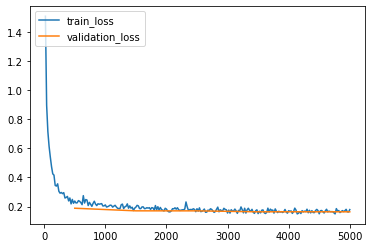

<Figure size 432x288 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
import json
# Plot validation and train loss on the same graph (because the Tensorboard doesn't plot them on same graph)
experiment_folder = 'output/dc5_base' #TODO: weight_file

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x.keys()], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x.keys()])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])

plt.legend(['train_loss', 'validation_loss'], loc='upper left')
plt.show()

# Save plot
plt.savefig(experiment_folder + '/dc5_base.png')

# Choose Threshold (on Validation Set)

In [19]:
base_test_folder = './output/dc5_base'

In [20]:
# Load images
loaded_imgs = []

print("Loading images started")
start_time = time.time()
for i, img in enumerate(dataset_dict_valid):
    loaded_imgs.append(cv2.imread(img['file_name']))
print(f"Loading images ended in {round(time.time()-start_time, 2)}")

Loading images started
Loading images ended in 2.02


In [21]:
def calc_iou(bbox1, bbox2):
    intersection = 0
    union = 0
    
    # Intersection
    x_left = max(bbox1[0], bbox2[0])
    y_bottom = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[2], bbox2[2])
    y_top = min(bbox1[3], bbox2[3])
    if x_right < x_left or y_bottom > y_top:
        return 0.
    intersection = (x_right - x_left) * (y_top - y_bottom)
    
    # Union
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    union = bbox1_area + bbox2_area - intersection
    
    return intersection / union

In [22]:
def order_bboxes(pred_output_bboxes, pred_output_cls, gt_bboxes, gt_cls):
    pred_output_bboxes_ordered = [None] * len(gt_bboxes)
    pred_output_cls_ordered = [None] * len(gt_cls)
    ious = [None] * len(gt_cls)
    
    for i, gt_bbox in enumerate(gt_bboxes):
        discard = True
        best_iou = 0.
        best_bbox = None
        best_cls = None
        for j, pred_output_bbox in enumerate(pred_output_bboxes):
            iou = calc_iou(pred_output_bbox, gt_bbox)
            if iou > 0.5:
                discard = True
            if discard and iou > best_iou:
                best_iou = iou
                best_cls = pred_output_cls
                best_bbox = pred_output_bbox
        
        if not discard:
            pred_output_bboxes_ordered[i] = best_bbox
            pred_output_cls_ordered[i] = best_cls
        
    return pred_output_cls_ordered, pred_output_bboxes_ordered

In [23]:
def get_conf_matrix(pred_cls, gt_cls):
    # Calculate confusion matrix
    TP = sum([pred_cls_==1 and gt_cls_==1 for pred_cls_, gt_cls_ in zip(pred_cls, gt_cls)])
    TN = sum([pred_cls_==0 and gt_cls_==0 for pred_cls_, gt_cls_ in zip(pred_cls, gt_cls)])
    FP = sum([pred_cls_==1 and gt_cls_==0 for pred_cls_, gt_cls_ in zip(pred_cls, gt_cls)])
    FN = sum([pred_cls_==0 and gt_cls_==1 for pred_cls_, gt_cls_ in zip(pred_cls, gt_cls)])
    
    return TP, TN, FP, FN

In [24]:
def get_average_precision(pred_cls, gt_cls):
    TP, TN, FP, FN = get_conf_matrix(pred_cls, gt_cls)
    
    return TP / (TP + FN) if TP + FN != 0 else 0

In [25]:
def get_average_recall(pred_cls, gt_cls):
    TP, TN, FP, FN = get_conf_matrix(pred_cls, gt_cls)
    
    return TP / (TP + FP) if TP + FP != 0 else 0

In [26]:
def get_f1(pred_cls, gt_cls):
    precision = get_average_precision(pred_cls, gt_cls)
    recall = get_average_recall(pred_cls, gt_cls)
    
    return 2*precision*recall / (precision+recall) if precision+recall != 0 else 0

In [27]:
# Calculate MAPs
mean_avg_precs = []
threshs = []
cfg.MODEL.WEIGHTS = os.path.join(base_test_folder, "model_final.pth")
final_bboxes = {}
final_cls = {}

for thresh in np.arange(0.1, 1., 0.1):
    # Init predictor every time with different thresh
    thresh = round(thresh, 1)
    start_time = time.time()
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = float(round(thresh, 1))
    predictor = DefaultPredictor(cfg)
    
    final_bboxes[thresh] = {}
    final_cls[thresh] = {}
    precisions = []
    
    for i, img in enumerate(dataset_dict_valid):
        outputs = predictor(loaded_imgs[i])
        
        pred_output_bboxes = outputs['instances'].to("cpu").pred_boxes.tensor.numpy()
        pred_output_cls = outputs['instances'].to("cpu").pred_classes.numpy()
        gt_bboxes = [annot['bbox'] for annot in img['annotations']]
        gt_cls = [annot['category_id'] for annot in img['annotations']]
        
        pred_cls_ordered, pred_bboxes_ordered = order_bboxes(pred_output_bboxes, pred_output_cls, gt_bboxes, gt_cls)
        
        precision = get_f1(pred_cls_ordered, gt_cls)
        precisions.append(precision)
        
        # Save the results of this threshold
        final_bboxes[thresh][img['file_name']] = pred_bboxes_ordered
        final_cls[thresh][img['file_name']] = pred_cls_ordered
    
    mean_avg_precs.append(sum(precisions) / len(precisions))
    threshs.append(thresh)
    
    print(f'Calculated for thresh={thresh} in {round(time.time()-start_time, 2)}')

Calculated for thresh=0.1 in 11.65
Calculated for thresh=0.2 in 11.68
Calculated for thresh=0.3 in 11.61
Calculated for thresh=0.4 in 11.7
Calculated for thresh=0.5 in 11.73
Calculated for thresh=0.6 in 11.75
Calculated for thresh=0.7 in 11.73
Calculated for thresh=0.8 in 11.83
Calculated for thresh=0.9 in 11.75


In [28]:
print(mean_avg_precs)
file_example = [key for key in final_cls[0.9].keys()][0]
print(len(final_cls[0.9][file_example]))
print(len(final_bboxes[0.9][file_example]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1
1


In [29]:
# Pick best performing threshold
best_thresh = threshs[int(np.argmax(mean_avg_precs))]
best_thresh

0.1

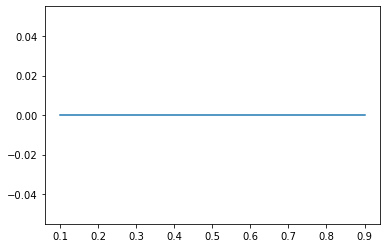

In [102]:
# Plot mAP (SAVE ITT!!)
plt.plot(threshs, mean_avg_precs)
plt.savefig('./output/dc5_base/dc5_base_map.jpg')

# Inference (on Test Set)

In [103]:
model_path = './output/dc5_base'
validation_path = model_path + '/validation'
base_test_folder = 'Dataset/TestData/images'

In [104]:
best_thresh

0.1

In [105]:
# change EXISTING cfg, only a bit for inference
cfg.MODEL.WEIGHTS = os.path.join(model_path, "model_final.pth")
best_thresh = 0.25
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = float(best_thresh)   # TODO: probaj i druge (napravi predikciju valid. seta sa razl threshovima pa napravi auc da usporedis razl. tresheve)

predictor = DefaultPredictor(cfg)

In [106]:
#from detectron2.utils.visualizer import ColorMode

#img_paths = [path for path in os.listdir('Dataset/TestData/images') if path.endswith('.tiff')]
#for img_path in os.listdir('Dataset/TestData/images')[:1]:
#    img = cv2.imread(os.path.join('Dataset/TestData/images', img_path))
#    outputs = predictor(img)
#    v = Visualizer(img[:, :, ::-1],
#              metadata=mitosis_metadata,
#              scale=0.5,
#              instance_mode=ColorMode.IMAGE_BW)
#    out = v.draw_instance_predictions(outputs['instances'].to('cpu'))
#    cv2.imwrite(f'output/faster_rcnn_base/prediction_{i}.tiff', out.get_image()[:, :, ::-1])
#    plt.imshow(out.get_image()[:, :, ::-1])

In [107]:
#def predict(img_path):
#    img = cv2.imread(img_path)
#    outputs = predictor(img)
#    bboxes = outputs['instances'].pred_boxes
#    lbls = outputs['instances'].pred_classes
#    return bboxes, lbls, img

In [108]:
                                            ### VISUALIZATION ###
def visualize_output(img_path, save=False):
    img = cv2.imread(img_path)
    outputs = predictor(img)
    bboxes = outputs['instances'].pred_boxes
    lbls = outputs['instances'].pred_classes
    
    v = Visualizer(img[:, :, ::-1],
              metadata=mitosis_metadata,
              scale=0.5)
    out = v.draw_instance_predictions(outputs['instances'].to('cpu'))
    plt.imshow(out.get_image()[:, :, ::-1])
    if save:
        idx = img_path.split('/')[-1].split('.')[0]
        idx = int(idx)
        if not os.path.exists('output/dc5_base/prediction_images'):
            os.makedirs('output/dc5_base/prediction_images')
        cv2.imwrite(f'output/dc5_base/prediction_images/prediction_{idx}.jpg', out.get_image()[:, :, ::-1])

In [109]:
example_img_path = 'Dataset/TrainData/images/085_0.tiff'

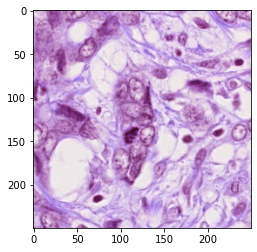

In [110]:
visualize_output(example_img_path, save=False)

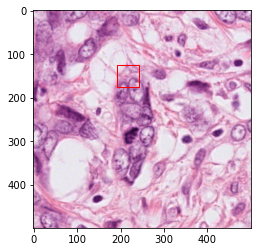

In [111]:
import matplotlib.patches as patches
from PIL import Image

im = Image.open(example_img_path)
fig, ax = plt.subplots()
ax.imshow(im)
annotations = [img['annotations'] for img in dataset_dict_train+dataset_dict_valid if img['file_name'] == example_img_path]
for annot in annotations[0]:
    bbox = annot['bbox']
    xmin, ymin, xmax, ymax = bbox
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [112]:
test_data = 'Dataset/TestData/images'

In [113]:
# Read the file
with open('Dataset/TestData/test_metadata.json') as f:
    annotation = json.load(f)
annotation['patches'][:3]

[{'bbox': [0, 0, 500, 500],
  'image_id': 0,
  'id': 0,
  'dilation_id': 0,
  'dilation_type': 'none'},
 {'bbox': [0, 500, 500, 1000],
  'image_id': 0,
  'id': 1,
  'dilation_id': 0,
  'dilation_type': 'none'},
 {'bbox': [0, 1000, 500, 1500],
  'image_id': 0,
  'id': 2,
  'dilation_id': 0,
  'dilation_type': 'none'}]

In [126]:
best_thresh = 0.7
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = float(best_thresh)   # TODO: probaj i druge (napravi predikciju valid. seta sa razl threshovima pa napravi auc da usporedis razl. tresheve)

In [136]:
import copy

# Inference on Test Data
img_paths = [path for path in os.listdir(test_data) if path.endswith('.tiff')]
bboxes = {}

for img_id, img_path in enumerate(os.listdir(test_data)):
    start_time = time.time()
    img = cv2.imread(os.path.join(test_data, img_path))
    
    # Crop the image using information from the annotation file
    for patch in annotation['patches']:
        # Skip patches that are not from this image
        if patch['image_id'] != img_id:
            continue
        xmin, ymin, xmax, ymax = patch['bbox']
        cropped_image = img[ymin:ymax, xmin:xmax]
        
        outputs = predictor(cropped_image)
        pred_output_bboxes = outputs['instances'].to("cpu").pred_boxes.tensor.numpy()
        pred_output_cls = outputs['instances'].to("cpu").pred_classes.numpy()
        
        for pred_bbox, pred_cls in zip(pred_output_bboxes, pred_output_cls):
            # Only add mitosis
            if pred_cls != 0:
                continue
            
            # Add xmin and ymin so it is in the domain of the original image
            pred_bbox = [pred_bbox[0]+xmin, pred_bbox[1]+ymin, pred_bbox[2]+xmin, pred_bbox[3]+ymax]
        
            # Save img_path/bbox where you found mitosis
            if img_path not in bboxes.keys():
                bboxes[img_path] = []
            bboxes[img_path].append((copy.deepcopy(pred_bbox), pred_cls))
    
    mitosis_num = sum([len(bbox) for bbox in bboxes.values()])
    print(f"Infered on image {(img_id+1)}/{len(img_paths)} in time {round(time.time()-start_time, 2)}, detected: {mitosis_num} mitoses")

Infered on image 1/34 in time 110.11, detected: 994 mitoses
Infered on image 2/34 in time 109.62, detected: 994 mitoses
Infered on image 3/34 in time 110.29, detected: 1007 mitoses
Infered on image 4/34 in time 109.19, detected: 1007 mitoses
Infered on image 5/34 in time 110.7, detected: 1154 mitoses
Infered on image 6/34 in time 110.29, detected: 1173 mitoses
Infered on image 7/34 in time 110.58, detected: 1235 mitoses
Infered on image 8/34 in time 110.39, detected: 1322 mitoses
Infered on image 9/34 in time 111.03, detected: 1415 mitoses
Infered on image 10/34 in time 110.28, detected: 1493 mitoses
Infered on image 11/34 in time 110.08, detected: 1493 mitoses
Infered on image 12/34 in time 110.47, detected: 1497 mitoses
Infered on image 13/34 in time 111.42, detected: 1671 mitoses
Infered on image 14/34 in time 109.6, detected: 1671 mitoses
Infered on image 15/34 in time 111.46, detected: 1945 mitoses
Infered on image 16/34 in time 110.51, detected: 2007 mitoses
Infered on image 17/3

KeyboardInterrupt: 

In [ ]:
# Non-max supression
new_bboxes = {}

for img_path in bbox.keys():
    temp = set()
    
    for i, (bbox1, pred1) in enumerate(bboxes[img_path]):
        for (bbox2, pred2) in bboxes[img_path][(i+1):]:
            iou = calc_iou(bbox1, bbox2)
            if pred1 < pred2:
                temp.add(bbox2)
            else:
                temp.add(bbox1)
                
    new_bboxes[img_path] = list(temp)

In [ ]:
bboxes = new_bboxes

#### Only thing that matters is the dict 'bboxes'

# Parse Inference for Submission

In [138]:
import pandas as pd
df = pd.DataFrame(columns=['slide', 'x', 'y'])

# Iterate over images
for img_path, bbox_list in bboxes.items():
    img_name = img_path.split('.')[0] + '/01.tif'
    
    # Iterate over each mitosis in images, and save it
    for bbox in bbox_list:
        x = (bbox[2] + bbox[0]) / 2
        y = (bbox[3] + bbox[1]) / 2
        df = df.append({'slide': img_name.split('/')[-1].split('.')[0], 'x': int(x), 'y': int(y)}, ignore_index=True)
    
df.to_csv('submission.csv', index=False)

In [137]:
sum([len(key) for key in bboxes.values()])

2474